# node2vec

### Setup

First of all, I will install the [graph2vec library](https://github.com/VHRanger/graph2vec) which offers a fast implementation of the node2vec method.

In [1]:
!pip install nodevectors

  Created wheel for nodevectors: filename=nodevectors-0.1.23-py3-none-any.whl size=17951 sha256=d0597edda77a3a0e9e6773f8ec04212285ab601618a95f8da17a91ffba954429
  Stored in directory: /root/.cache/pip/wheels/6e/6a/11/ac8620f101db6248c3cd436636eb17f6f7430cd1ac3a3068dc
  Created wheel for csrgraph: filename=csrgraph-0.1.28-py3-none-any.whl size=17632 sha256=4171ab2821d063ad0e2ea72b8ae60b4a7aaccd233c8bdfcf27ec1056ac1a317d
  Stored in directory: /root/.cache/pip/wheels/3d/0a/58/36a63805f1cd719cbcc5a3c4c109604985a809e7d81bac1649
Successfully built nodevectors csrgraph


I now import the library, and create a small wrapper class which will expose only the few hyperparameters I will need to tune in this Colab

In [2]:
import nodevectors
import networkx as nx

class Node2Vec(nodevectors.Node2Vec):
  """
  Parameters
  ----------
  p : float
      p parameter of node2vec
  q : float
      q parameter of node2vec
  d : int
      dimensionality of the embedding vectors
  """
  def __init__(self, p=1, q=1, d=32):
    super().__init__(
                     n_components=d,
                     walklen=10,
                     epochs=50,
                     return_weight=1.0/p,
                     neighbor_weight=1.0/q,
                     threads=0,
                     w2vparams={'window': 4,
                                'negative': 5, 
                                'iter': 10,
                                'batch_words': 128})

Lastly, let's import some of the common libraries needed for the task.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Load the Zachary's Karate Club as a NetworkX Graph object
KCG = nx.karate_club_graph()

# Fit embedding model to the Karate Club graph
n2v = Node2Vec(1, 1, 2)
n2v.fit(KCG)

Making walks... 

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Done, T=3.38
Mapping Walk Names... Done, T=0.04
Training W2V... Done, T=0.35


In [5]:
embeddings = []
for node in KCG.nodes:
  embedding = list(n2v.predict(node))
  club = KCG.nodes[node]['club']
  embeddings.append(embedding + [club])

# Construct a pandas dataframe with the 2D embeddings from node2vec,
# plus the club name that each node belongs to after the split
df = pd.DataFrame(embeddings, columns=['x', 'y', 'club'])

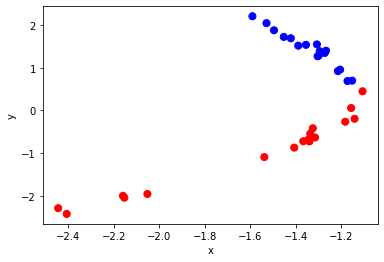

In [6]:
# Nodes who stayed with the Mr. Hi will be plotted in red, while nodes
# who moved with the Officer will be plotted in blue
colors = ['red' if x == 'Mr. Hi' else 'blue' for x in df.club]
df.plot.scatter(x='x', y='y', s=50, c=colors)

If my example trained correctly, We may notice a clear separation between the blue and red nodes.  Solely from the graph structure, node2vec could predict how the Zachary's Karate Club split!

Tune the hyperparameters ```p``` and ```q```, and notice how they affect the resulting embeddings.

### Building node2vec

Now we will study the behavior of node2vec on [barbell graphs](https://en.wikipedia.org/wiki/Barbell_graph).

Below we can see a toy example of a barbell graph generated with NetworkX.

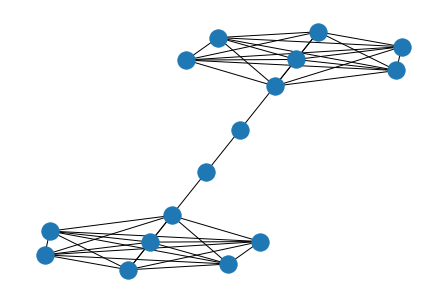

In [7]:
toy_barbell = nx.barbell_graph(7, 2)
nx.draw_kamada_kawai(toy_barbell)



```
# This is formatted as code
```

Generate a larger barbell graph, where each complete graph has exactly 1000 nodes, and the path length between the complete graphs is equal to 1 (i.e., all the nodes in the barbell graph belong to either one of the two complete graphs, and the connecting path does not have any internal node).

Then, learn node2vec embeddings on this graph, setting ```p = 1, q = 1``` and ```d = 10```.

In [8]:
barbell = nx.barbell_graph(500, 0)

In [9]:
n2v_barbell = Node2Vec(1, 1, 10)
n2v_barbell.fit(barbell)

Making walks... Done, T=0.16
Mapping Walk Names... Done, T=0.70
Training W2V... Done, T=14.15


Now, I am going to write a function that takes as input a node id ```n``` in the graph (e.g., ```5```) and returns a list containining the cosine similarity between the node2vec vector of the input node ```n``` and all the nodes in the given barbell graph (including the similarity with ```n``` itself).

In [10]:
from numpy.linalg import norm

def get_similarity(n, g=barbell, embed=n2v_barbell):
    cos = []
    e = embed.predict(n)
    for node in barbell.nodes:
        e_n = embed.predict(node)
        cos.append( (e @ e_n) / (norm(e) * norm(e_n)))
    return cos

Now, I am going to generate another barbell graph, this time adding a path of length 51 between the two complete graphs. To find out how, refer to the NetworkX documentation: [https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.classic.barbell_graph.html#networkx.generators.classic.barbell_graph](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.classic.barbell_graph.html#networkx.generators.classic.barbell_graph)

I am using the node2vec embeddings for the nodes of this new graph, using the same hyperparameters as before.

In [11]:
barbell_51 = nx.barbell_graph(500, 51)
n2v_barbell_51 = Node2Vec(1, 1, 10)
n2v_barbell_51.fit(barbell_51)

Making walks... Done, T=0.15
Mapping Walk Names... Done, T=0.57
Training W2V... Done, T=14.72


(array([500.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 500.]),
 array([0.07291815, 0.16562633, 0.25833452, 0.3510427 , 0.44375086,
        0.536459  , 0.6291672 , 0.7218754 , 0.8145836 , 0.90729177,
        0.99999994], dtype=float32),
 <a list of 10 Patch objects>)

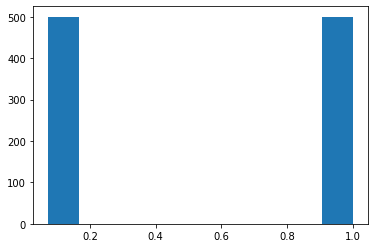

In [12]:
plt.hist(get_similarity(5))

(array([  3., 447.,   8.,  34.,   9.,   0.,   0.,   0.,   0., 499.]),
 array([0.00309058, 0.10278152, 0.20247245, 0.3021634 , 0.40185434,
        0.50154525, 0.6012362 , 0.70092714, 0.80061805, 0.900309  ,
        0.99999994], dtype=float32),
 <a list of 10 Patch objects>)

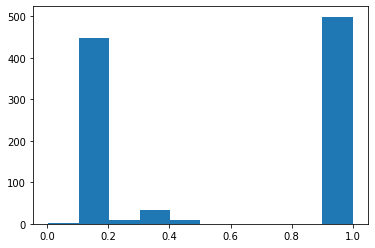

In [13]:
plt.hist(get_similarity(5, barbell_51, n2v_barbell_51))